In [45]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from pprint import pprint
from scipy.signal import find_peaks


In [ ]:
data_dir = r"C:\Users\yrliu98\Desktop\20250409"

xy_files = list(Path(data_dir).glob('*.xy'))

# to_exclude = [1, 2, 3, 5, 6, 7]

# for i in sorted(to_exclude, reverse=True):
#     xy_files.pop(i)

pprint(xy_files)

[WindowsPath('C:/Users/yrliu98/Desktop/20250409/2D_PYSK_2STEP_A01_merge_exported.xy'),
 WindowsPath('C:/Users/yrliu98/Desktop/20250409/2D_PYSK_2STEP_B01_merge_exported.xy'),
 WindowsPath('C:/Users/yrliu98/Desktop/20250409/cyrene_ACN_01_001_exported.xy')]


In [88]:
Co_K_alpha = 1.7902
Cu_K_alpha = 1.5406

dfs = []
for xy_file in xy_files:
    df = pd.read_csv(xy_file, sep=" ", skiprows=1, names=["2theta_Co", "int"])
    df = df.assign(**{
        "2theta_Cu": lambda x: x["2theta_Co"] * Co_K_alpha / Cu_K_alpha
    })

    df = df[(df["2theta_Cu"] > 5) & (df["2theta_Cu"] < 50.5)]

    peaks, _ = find_peaks(df["int"], prominence=[0.6, None])

    dfs.append({"name": xy_file.stem.replace("_exported", ""), **df.to_dict(orient='list')})



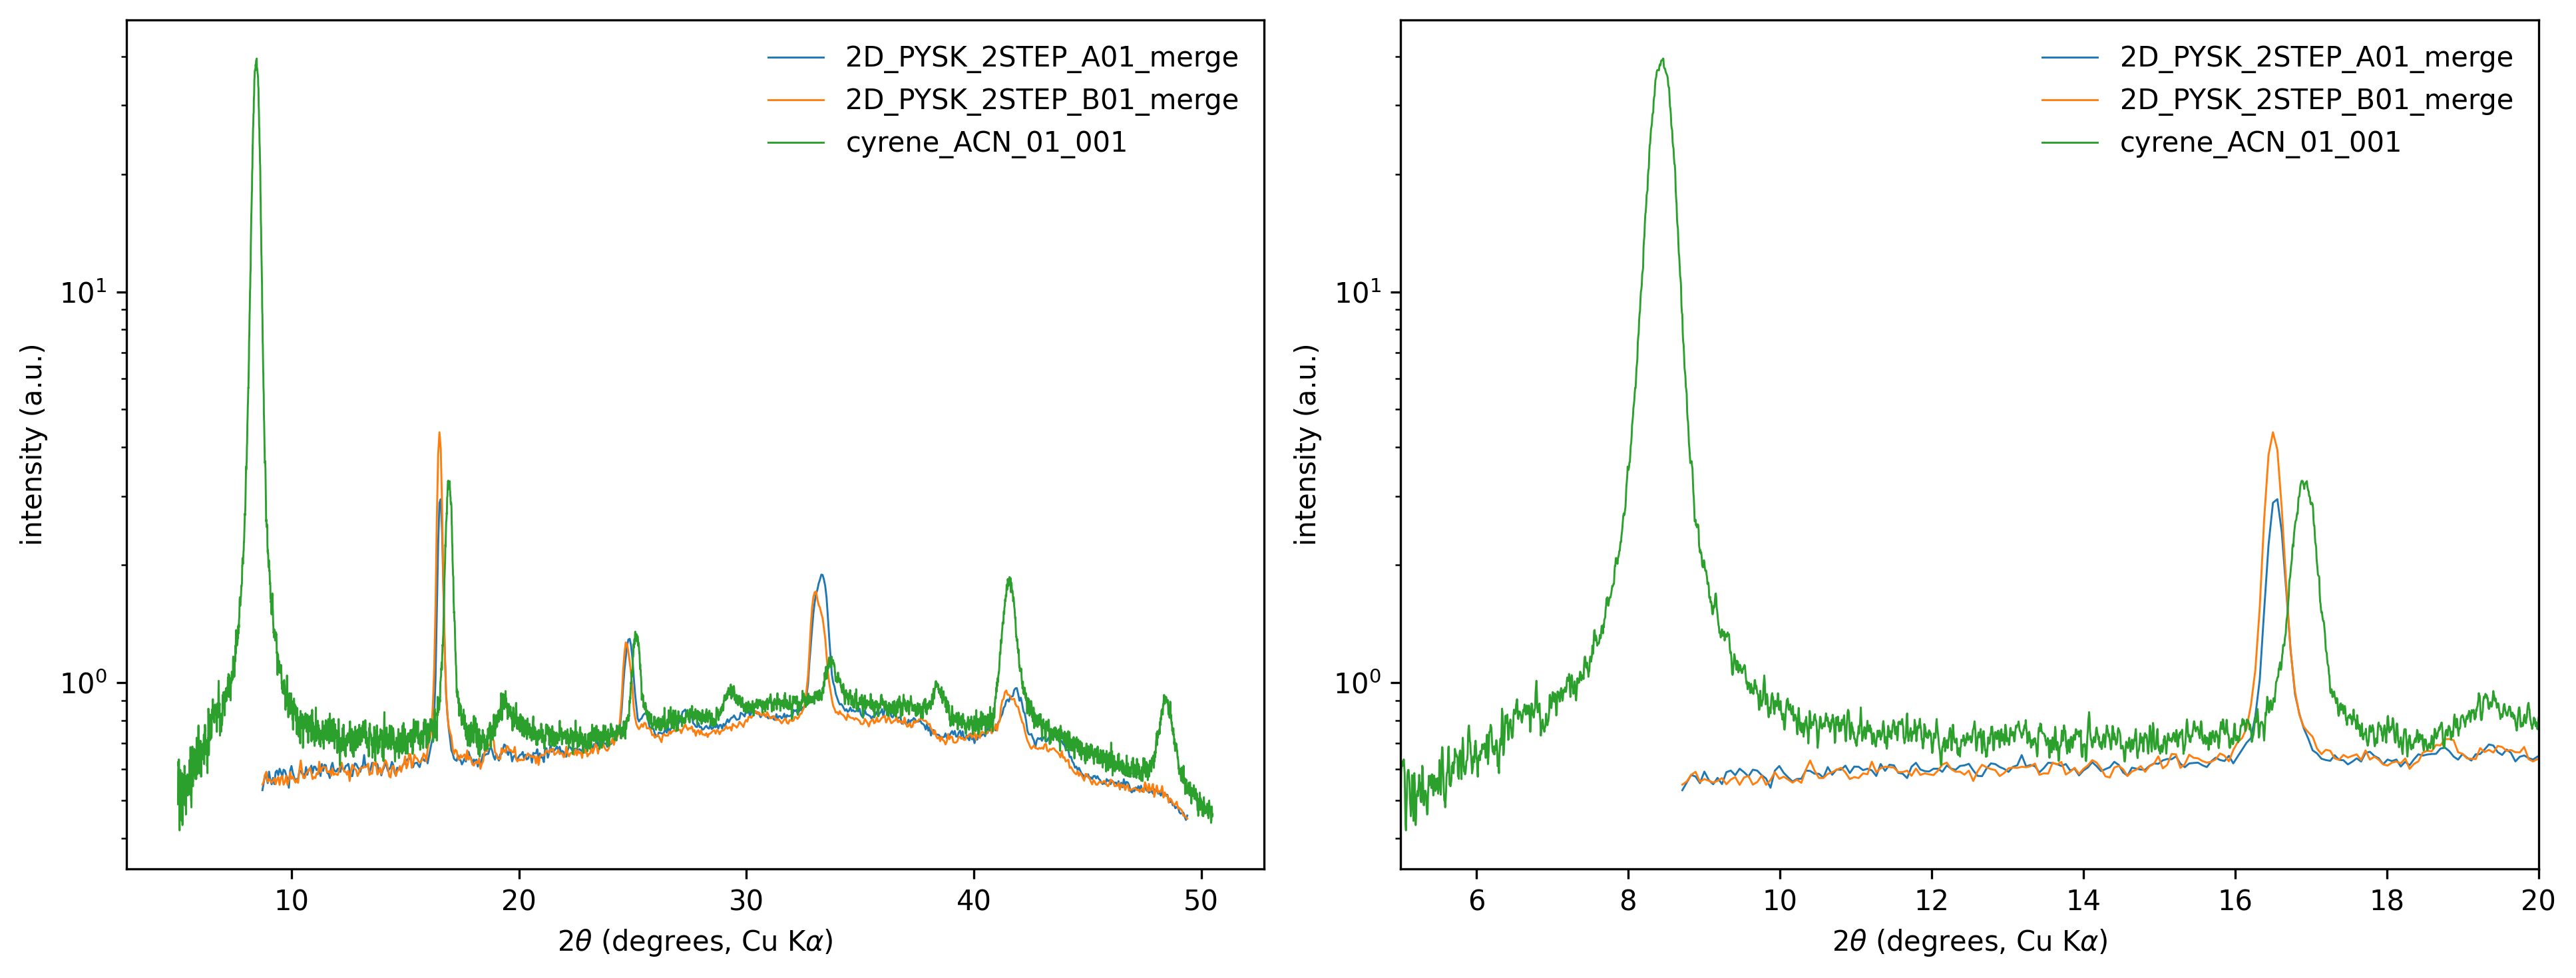

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=300, layout="tight")

for ax in axs:
    for df in dfs:
        ax.plot(df["2theta_Cu"], df["int"], label=df["name"], lw=0.7)

    handles, labels = ax.get_legend_handles_labels()
    order = [1, 3, 2, 0]
    if len(order) == len(dfs):
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False)
    else:
        ax.legend(frameon=False)

    ax.set_yscale('log')
    ax.set_xlabel("$2\\theta$ (degrees, Cu K$\\alpha$)")
    ax.set_ylabel("intensity (a.u.)")

axs[1].set_xlim(5, 20)

fig.savefig(Path(data_dir, "plot.jpg"))
